In [1]:
from glob import glob
import matplotlib.pyplot as plt
import os
import os.path
import configparser 
import requests
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
from pathlib import Path
pd.set_option('display.max_columns', None)

In [2]:
import sys
sys.path.append('..')
from data_stadt_sg import get_traktandierte_geschaefte
sys.executable

'/home/toedtli/miniforge3/envs/male/bin/python3'

In [3]:
config = configparser.ConfigParser()
config.read('../config.ini', encoding='utf-8')
print(list(config.keys()))
config

['DEFAULT', 'Verzeichnisse', 'Links', 'Einstellungen']


In [4]:
ScratchPfad = Path(config['Verzeichnisse']['Verarbeitungspfad'])
Text_Pfad = ScratchPfad/'Text'

lade neueste Version der .csv-Datei von der opendatasg-Plattform herunter:

In [5]:
df = get_traktandierte_geschaefte('../config.ini')
df.Sitzungsdatum.min(),df.Sitzungsdatum.max()

wrote to /home/toedtli/opendatasg/input/traktandierte-geschaefte-sitzungen-stadtparlament-stgallen.csv.


('2000-12-19', '2023-12-05')

In [6]:
traktandierte_geschaefte_input_csv = config['Verzeichnisse']['inputcsv']
traktandierte_geschaefte_input_csv

'/home/toedtli/opendatasg/input/traktandierte-geschaefte-sitzungen-stadtparlament-stgallen.csv'

# Preprocessing

In [7]:
list(config['Verzeichnisse'].keys())
df = pd.read_csv(traktandierte_geschaefte_input_csv,sep=';')
df['Sitzungsdatum']=df[['Sitzungsdatum']].astype('datetime64[ns]')
#df['Legislatur']=df[['Legislatur']].astype('datetime64[ns]')
df['Dokumentendatum']=df[['Dokumentendatum']].astype('datetime64[ns]')
df['Legislatur start'] = pd.to_datetime(df.Legislatur.str.split(' - ',expand=True).iloc[:,0],dayfirst=True)
df['Legislatur end'] = pd.to_datetime(df.Legislatur.str.split(' - ',expand=True).iloc[:,1],dayfirst=True)
#df_behandelt = df[df.Traktandenstatus=='behandelt'] # Nur erste Erwähnung
#Alle Geschäftstypen ausser "Sachgeschäft" werden vom Parlament behandelt- Sachgeschäfte (der Verwaltung?) interessieren erst mal nicht
Parlamentsaktivitäten = ['Parlamentarische Vorstösse/Interpellation','Parlamentarische Vorstösse/Postulat','Parlamentarische Vorstösse/Einfache Anfrage','Parlamentarische Vorstösse/Motion']#,'Wahl']
df_Parlament = df[df.Geschaeftstyp.isin(Parlamentsaktivitäten)]
df.shape

(4117, 38)

In [8]:
df['Traktandenstatus'].unique()

array(['behandelt', 'verschoben', nan], dtype=object)

In [9]:
df_Parlament.head()

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Traktandum_GUID,Legislatur start,Legislatur end
1,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2d76d27f9b4e4ed087d04ea83c1e60b5,2017-01-01,2020-12-31
2,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,e5bab329501544f9b51d800330171ad0,2017-01-01,2020-12-31
3,2020-09-22T00:00:00.000-19,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/bd0fd41e0...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP/JUSO/PFG-Fraktion: Reglement...,NaN,behandelt,19.0,bd0fd41e0ebd454b9c11be26337c9066,92d6c27378234db28fa9b377d7f41345,2017-01-01,2020-12-31
4,2020-10-27T00:00:00.000-10,f204718502654abf8818edc73721d4c0,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,50. Sitzung Stadtparlament,2020-10-27,Öffentlich,Olma Messen; Halle 2.1,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/f20471850...,https://ftp-sg.oca.ch/stadtparlament/15124570b...,152.15.11 Stadtparlament: Postulate,Parlamentarische Vorstösse/Postulat,NaN,NaN,https:/

In [10]:
df_Parlament

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Traktandum_GUID,Legislatur start,Legislatur end
1,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2d76d27f9b4e4ed087d04ea83c1e60b5,2017-01-01,2020-12-31
2,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,e5bab329501544f9b51d800330171ad0,2017-01-01,2020-12-31
3,2020-09-22T00:00:00.000-19,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/bd0fd41e0...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP/JUSO/PFG-Fraktion: Reglement...,NaN,behandelt,19.0,bd0fd41e0ebd454b9c11be26337c9066,92d6c27378234db28fa9b377d7f41345,2017-01-01,2020-12-31
4,2020-10-27T00:00:00.000-10,f204718502654abf8818edc73721d4c0,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,50. Sitzung Stadtparlament,2020-10-27,Öffentlich,Olma Messen; Halle 2.1,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/f20471850...,https://ftp-sg.oca.ch/stadtparlament/15124570b...,152.15.11 Stadtparlament: Postulate,Parlamentarische Vorstösse/Postulat,NaN,NaN,https:/

In [11]:
df_Parlament[['Geschaeft_GUID','Download Traktandumsdokumente']].groupby('Download Traktandumsdokumente').count().max()

Geschaeft_GUID    7
dtype: int64

Das Problem ist, dass die Dokumente nicht pro Traktandum zusammengefasst sind, sondern pro Geschäft. Es gibt mehr als ein Traktandum pro Geschäft, womit die Geschaeft_GUID sich nicht als Index eignet.  
Wir werden alle Dokumente pro Geschäft zusammenfassen und Geschäfte analysieren. Aktuell fehlt eine feinere Dokumentation pro Traktandum.

Die nächste Zelle motiviert die Einschränkung von `df` auf `df_Parlament`: Ausser den Sachgeschäften werden alle Geschäfte vom Parlament verhandelt

In [12]:
df.Geschaeftstyp.value_counts()

Geschaeftstyp
Sachgeschäft                                   1878
Parlamentarische Vorstösse/Interpellation       978
Parlamentarische Vorstösse/Postulat             482
Parlamentarische Vorstösse/Einfache Anfrage     403
Wahl                                            206
Parlamentarische Vorstösse/Motion               149
Diverses                                          8
Name: count, dtype: int64

Übrig bleiben nur Stadtparlamentssitungen:

In [13]:
df_Parlament[df_Parlament.Geschaeftstyp=='Wahl'].Bezeichnung.unique()[:3]

array([], dtype=object)

# Erste Einsichten
## Wo fanden die Sitzungen statt?

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Olma Messen; Halle 2.1'),
  Text(1, 0, 'Olma Messen'),
  Text(2, 0, 'Olma - Halle 2.1'),
  Text(3, 0, 'Olma'),
  Text(4, 0, 'Waaghaus'),
  Text(5, 0, 'Kantonsratssaal / Regierungsgebäude'),
  Text(6, 0, 'Sporthalle Kreuzbleiche'),
  Text(7, 0, 'Kantonsratssaal; open end mit Imbiss')])

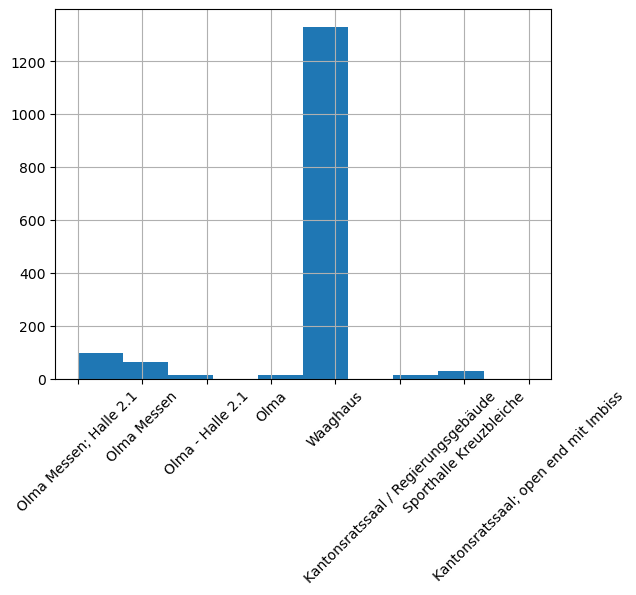

In [14]:
df_Parlament.Ort.hist()
plt.xticks(rotation=45)

In [15]:
df_Parlament.Traktandenstatus.unique()

array(['behandelt', 'verschoben', nan], dtype=object)

In [16]:
df_Parlament.Geschaeft_GUID.value_counts()

Geschaeft_GUID
7ed62416b0d04a0cb61a9906e840f064    7
dd01e62d83ee464aa6c94b260f0ed7bf    6
ba2b0a4dc78a486baf23f41960345a8e    6
9726b44f38f3428b9d3015a261d01ded    6
7c08bf57169d43c882804bbfe7d7c243    5
                                   ..
119a37ceba5b47e98a006a42e3ab85d2    1
8544ffabb1fc401c8196533d5ac27c0c    1
30680909d3b84665be53482dec26dfcb    1
21258a39c44444f5b33e841a896bb6e9    1
fb7f440fe54a481f8d0ccb143e704fe3    1
Name: count, Length: 1207, dtype: int64

In [17]:
df_Parlament[df_Parlament.Geschaeft_GUID=='7529adcfdf27400290615606b74d98ec'].Traktandentitel.map(print)

Einfache Anfrage Konstantin Hälg: Cybersicherheit der Stadt St.Gallen; Beantwortung


836    None
Name: Traktandentitel, dtype: object

In [18]:
guid_sitzung = df_Parlament[df_Parlament.Geschaeft_GUID=='7529adcfdf27400290615606b74d98ec']
guid_sitzung

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Traktandum_GUID,Legislatur start,Legislatur end
836,2021-05-04T00:00:00.000-18,10f602026c7940f2877179ee3c7e3a90,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2021 - 31.12.2024,2021,4. Sitzung Stadtparlament,2021-05-04,Öffentlich,Olma Messen,Halle 2.1,bis 20.00 Uhr,https://ftp-sg.oca.ch/stadtparlament/10f602026...,https://ftp-sg.oca.ch/stadtparlament/592930de1...,152.15.13 Stadtparlament: Einfache Anfragen,Parlamentarische Vorstösse/Einfache Anfrage,Hälg Konstantin,JF,https://ftp-sg.oca.ch/stadtparlament/7529adcfd...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.13,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.13,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Einfache Anfragen,NaN,2021-04-20,Beschlussprotokoll Stadtparlament mit Abstimmu...,Einfache Anfrage Konstantin Hälg: Cybersicherh...,NaN,behandelt,18.0,7529adcfdf27400290615606b74d98ec,5cdf03eb6559489c80386ceca082fd18,2021-01-01,2024-12-31


In [19]:
#Traktanden werden mehrfach gesetzt- berücksichtige nur das erste mal, denn dann wurde es thematisch relevant (Abschliessende Behandlung kann Jahre dauern)
L =  []
for guid in df_Parlament.Geschaeft_GUID.unique():
    sublist_idx = df_Parlament[df_Parlament.Geschaeft_GUID==guid].Sitzungsdatum.argmin()
    earliest = df_Parlament[df_Parlament.Geschaeft_GUID==guid].iloc[sublist_idx,:]
    L.append(earliest)
df_Parlament_earliest = pd.DataFrame(L)

In [20]:
df_Parlament_earliest.Geschaeft_GUID.value_counts().max()
df_Parlament.shape,df_Parlament_earliest.shape

((2012, 38), (1207, 38))

In [21]:
for guid in df_Parlament.Geschaeft_GUID.unique():
    df_Parlament[df_Parlament.Geschaeft_GUID=='af743b6a1d6a4b549ccd24b25bfe64f8'].Sitzungsdatum.argmin()

In [22]:
df_Parlament[df_Parlament.Geschaeft_GUID=='af743b6a1d6a4b549ccd24b25bfe64f8']['Link zur Sitzung'].tolist()

['https://www.stadt.sg.ch/home/verwaltung-politik/demokratie-politik/stadtparlament/sitzungen/2021_2024.sitzungDetail.html?sitzungGUID=c26f59a0c7c24896a7c95c52759b9f64',
 'https://www.stadt.sg.ch/home/verwaltung-politik/demokratie-politik/stadtparlament/sitzungen/2021_2024.sitzungDetail.html?sitzungGUID=d2a17e5a8d014149b6cc17d50abc7705',
 'https://www.stadt.sg.ch/home/verwaltung-politik/demokratie-politik/stadtparlament/sitzungen/2017_2020.sitzungDetail.html?sitzungGUID=e46b7e5c450c45dab4d14abc5cd412f7',
 'https://www.stadt.sg.ch/home/verwaltung-politik/demokratie-politik/stadtparlament/sitzungen/2017_2020.sitzungDetail.html?sitzungGUID=2ea4df3af05d414dbf53d2dc01c36ba3']

## Wieviele Geschäfte gab's pro Legislatur?

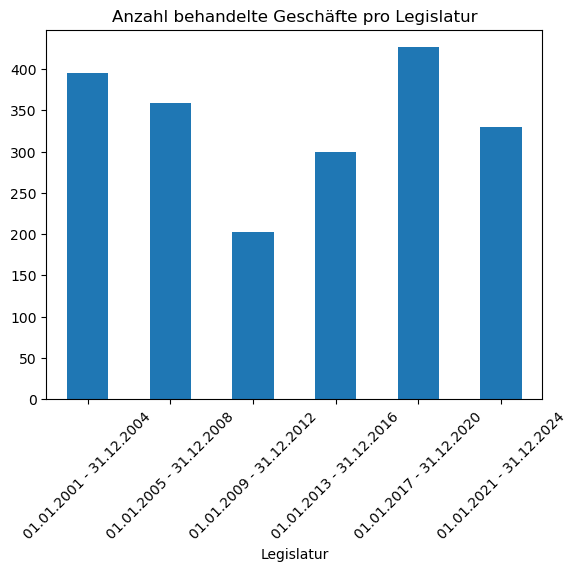

In [23]:
df_Parlament['Legislatur'].value_counts().sort_index().plot.bar();
plt.title('Anzahl behandelte Geschäfte pro Legislatur')
plt.xticks(rotation=45);

<Axes: title={'center': 'Aktenplan Ebene 4'}, xlabel='Aktenplan Ebene4'>

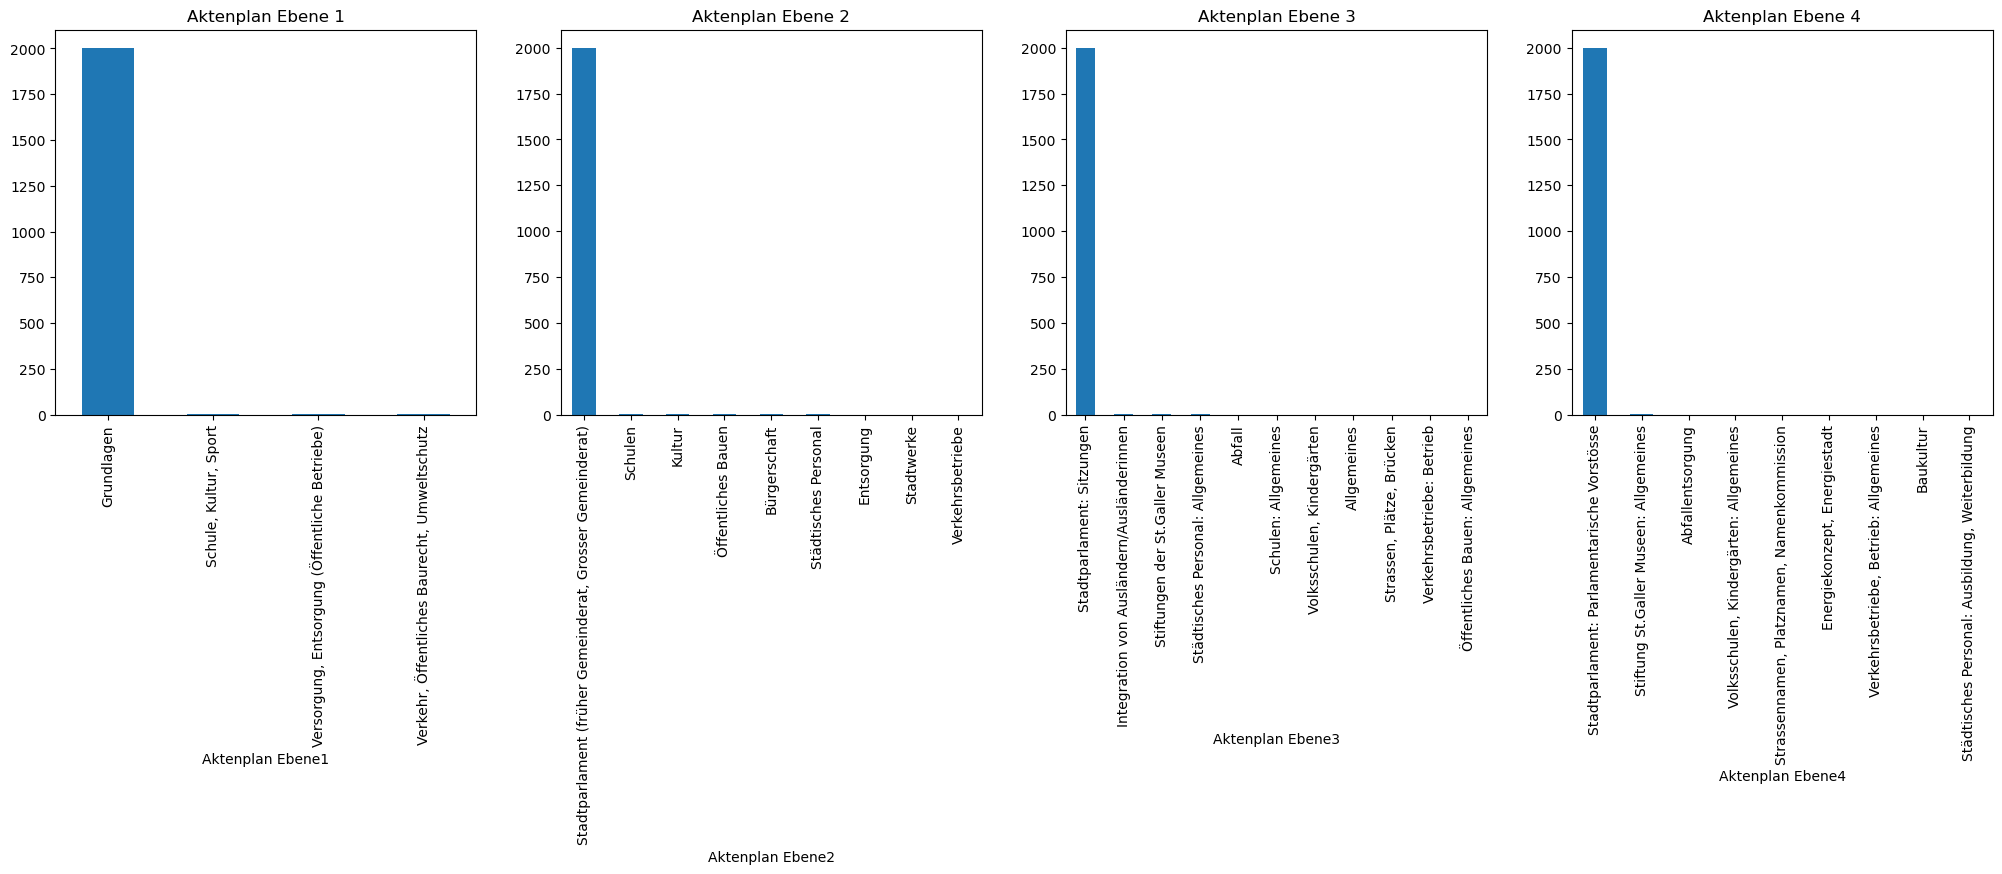

In [24]:
fig,axs = plt.subplots(1,4,figsize=(25,5))
df_Parlament['Aktenplan Ebene1'].value_counts().plot.bar(ax=axs[0],title='Aktenplan Ebene 1')
df_Parlament['Aktenplan Ebene2'].value_counts().plot.bar(ax=axs[1],title='Aktenplan Ebene 2')
df_Parlament['Aktenplan Ebene3'].value_counts().plot.bar(ax=axs[2],title='Aktenplan Ebene 3')
df_Parlament['Aktenplan Ebene4'].value_counts().plot.bar(ax=axs[3],title='Aktenplan Ebene 4')

Das ist nicht sehr aufschlussreich! Wir hätten gerne inhaltliche Informationen zu den Stadtparlamentssitzungen. Dazu brauchen wir NLP.

In [25]:
Stadtparlament_txt = df_Parlament['Aktenplan Ebene2'].value_counts().idxmax()
df_Parlament_gem_AP = df_Parlament[df_Parlament['Aktenplan Ebene2']==Stadtparlament_txt]  #Diese Einschränkung auf ein bestimmtes Element in der Aktenplanebene 2 ist nochmals gut zu überdenken! Nicola fragen...
df_Parlament_gem_AP.head()

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Traktandum_GUID,Legislatur start,Legislatur end
1,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2d76d27f9b4e4ed087d04ea83c1e60b5,2017-01-01,2020-12-31
2,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,e5bab329501544f9b51d800330171ad0,2017-01-01,2020-12-31
3,2020-09-22T00:00:00.000-19,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/bd0fd41e0...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP/JUSO/PFG-Fraktion: Reglement...,NaN,behandelt,19.0,bd0fd41e0ebd454b9c11be26337c9066,92d6c27378234db28fa9b377d7f41345,2017-01-01,2020-12-31
4,2020-10-27T00:00:00.000-10,f204718502654abf8818edc73721d4c0,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,50. Sitzung Stadtparlament,2020-10-27,Öffentlich,Olma Messen; Halle 2.1,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/f20471850...,https://ftp-sg.oca.ch/stadtparlament/15124570b...,152.15.11 Stadtparlament: Postulate,Parlamentarische Vorstösse/Postulat,NaN,NaN,https:/

In [26]:
#Die Aktenplan Auskunft scheint nicht immer über alle Zweifel erhaben. Warum gibt es Geschäftstypen "Parlamentarische Vorstösse/Einfache Anfrage",
#wenn der Eintrag nicht zur Aktenplan Ebene 2 gehört?!
df_Parlament[(df_Parlament['Aktenplan Ebene2']!=Stadtparlament_txt)&(df_Parlament.Geschaeftstyp!='Wahl')].sample(3)

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Traktandum_GUID,Legislatur start,Legislatur end
1814,2008-10-28T00:00:00.000-12,99a7e62fa8bc487fb29606e9ff755722,NaN,01.01.2005 - 31.12.2008,2008,59. Sitzung Stadtparlament,2008-10-28,Öffentlich,NaN,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/99a7e62fa...,https://ftp-sg.oca.ch/stadtparlament/7f2d9c078...,138 Integration von Ausländern / Ausländerinnen,Parlamentarische Vorstösse/Postulat,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/c12e41ac6...,https://www.stadt.sg.ch/home/verwaltung-politi...,138,1 Grundlagen / 13 Bürgerschaft / 138 Integrati...,1 / 13 / 138,Grundlagen,Bürgerschaft,Integration von Ausländern/Ausländerinnen,NaN,NaN,NaN,2012-09-17,Protokoll StParl 28.10.2008,Postulat Martin Bösch: Quartierentwicklung: Ei...,NaN,behandelt,12.0,c12e41ac64e34670b9da895f4af5ba56,826c8465327f498d848069910f43aa2a,2005-01-01,2008-12-31
1798,2012-05-08T00:00:00.000-5,9696ea6b868b48d098ed7d660d271ca2,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2009 - 31.12.2012,2012,44. Sitzung Stadtparlament,2012-05-08,Öffentlich,NaN,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/9696ea6b8...,https://ftp-sg.oca.ch/stadtparlament/fb5fc9814...,"510.20 Energiekonzept, Energiestadt",Parlamentarische Vorstösse/Interpellation,Bertoldo Daniel;Knaus Markus,EVP;EVP,https://ftp-sg.oca.ch/stadtparlament/79a6dba23...,https://www.stadt.sg.ch/home/verwaltung-politi...,510.20,"5 Versorgung, Entsorgung (Öffentliche Betriebe...",5 / 51 / 510 / 510.20,"Versorgung, Entsorgung (Öffentliche Betriebe)",Stadtwerke,Allgemeines,"Energiekonzept, Energiestadt",NaN,NaN,2012-08-28,Protokoll StParl 08.05.2012,Interpellation Daniel Knaus und Daniel Bertold...,NaN,behandelt,5.0,79a6dba23beb4468853791a90907f52d,07bc2500d2e04265ae25c5e3bb236e03,2009-01-01,2012-12-31
3803,2013-06-11T00:00:00.000-10,fe709dac528e4a51a2ae1994c605b90f,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2013 - 31.12.2016,2013,6. Sitzung Stadtparlament,2013-06-11,Öffentlich,Waaghaus,16:00,NaN,https://ftp-sg.oca.ch/stadtparlament/fe709dac5...,https://ftp-sg.oca.ch/stadtparlament/b806b42ec...,"190.20 Städtisches Personal: Ausbildung, Weite...",Parlamentarische Vorstösse/Postulat,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/21258a39c...,https://www.stadt.sg.ch/home/verwaltung-politi...,190.20,1 Grundlagen / 19 Städtisches Personal / 190 S...,1 / 19 / 190 / 190.20,Grundlagen,Städtisches Personal,Städtisches Personal: Allgemeines,"Städtisches Personal: Ausbildung, Weiterbildung",NaN,NaN,2013-06-20,Protokoll StParl 11.06.2013,Ausbau des Lehrstellangebots in der Stadt St.G...,NaN,behandelt,10.0,21258a39c44444f5b33e841a896bb6e9,441389ebcd7248c5b805fafda0f0f291,2013-01-01,2016-12-31


In [27]:
for col in df_Parlament_gem_AP.columns:
    print(f'{col:>30}{df[col].nunique():>30}')

                            nr                          4115
                   Sitzungs_ID                           320
              Link zur Sitzung                           196
                    Legislatur                             6
                          Jahr                            24
                   Bezeichnung                            95
                 Sitzungsdatum                           320
                      Freigabe                             1
                           Ort                             8
                          Zeit                             5
                   Bemerkungen                            69
              Download_Sitzung                           318
            Download_Protokoll                           313
                     Aktenplan                           390
                 Geschaeftstyp                             7
                        Person                           481
                        

In [28]:
for col in df_Parlament_gem_AP.columns:
    if df[col].nunique()<10:
        print('\n')
        display(df[col].value_counts())

Legislatur
01.01.2001 - 31.12.2004    852
01.01.2017 - 31.12.2020    807
01.01.2005 - 31.12.2008    763
01.01.2013 - 31.12.2016    603
01.01.2021 - 31.12.2024    576
01.01.2009 - 31.12.2012    516
Name: count, dtype: int64

Freigabe
Öffentlich    4117
Name: count, dtype: int64

Ort
Waaghaus                                2670
Olma Messen; Halle 2.1                   178
Olma Messen                              102
Sporthalle Kreuzbleiche                   59
Olma                                      25
Olma - Halle 2.1                          22
Kantonsratssaal / Regierungsgebäude       17
Kantonsratssaal; open end mit Imbiss       3
Name: count, dtype: int64

Zeit
16:00          2545
Halle 2.1       102
Halle 9.1.2      25
14:00             3
18:00             1
Name: count, dtype: int64

Geschaeftstyp
Sachgeschäft                                   1878
Parlamentarische Vorstösse/Interpellation       978
Parlamentarische Vorstösse/Postulat             482
Parlamentarische Vorstösse/Einfache Anfrage     403
Wahl                                            206
Parlamentarische Vorstösse/Motion               149
Diverses                                          8
Name: count, dtype: int64

Aktenplan Ebene1
Grundlagen                                                             2511
Verkehr, Öffentliches Baurecht, Umweltschutz                            420
Versorgung, Entsorgung (Öffentliche Betriebe)                           399
Schule, Kultur, Sport                                                   334
Öffentliche Finanzen                                                    211
Gesundheit, Soziales, Sozialhilfe                                        95
Öffentliche Ordnung und Sicherheit, Landesverteidigung, Zivilschutz      62
Wirtschaft                                                               40
Recht, Rechtspflege; Bund, Kanton, Gemeinde                               7
Name: count, dtype: int64

Series([], Name: count, dtype: int64)

Series([], Name: count, dtype: int64)

Traktandenstatus
behandelt     2877
verschoben     737
Name: count, dtype: int64

Legislatur start
2001-01-01    852
2017-01-01    807
2005-01-01    763
2013-01-01    603
2021-01-01    576
2009-01-01    516
Name: count, dtype: int64

Legislatur end
2004-12-31    852
2020-12-31    807
2008-12-31    763
2016-12-31    603
2024-12-31    576
2012-12-31    516
Name: count, dtype: int64

Text(0.5, 1.0, 'Anzahl behandelte Traktanden (Aktenplan Ebene 2=Stadtparlament (früher Gemeinderat, Grosser Gemeinderat)')

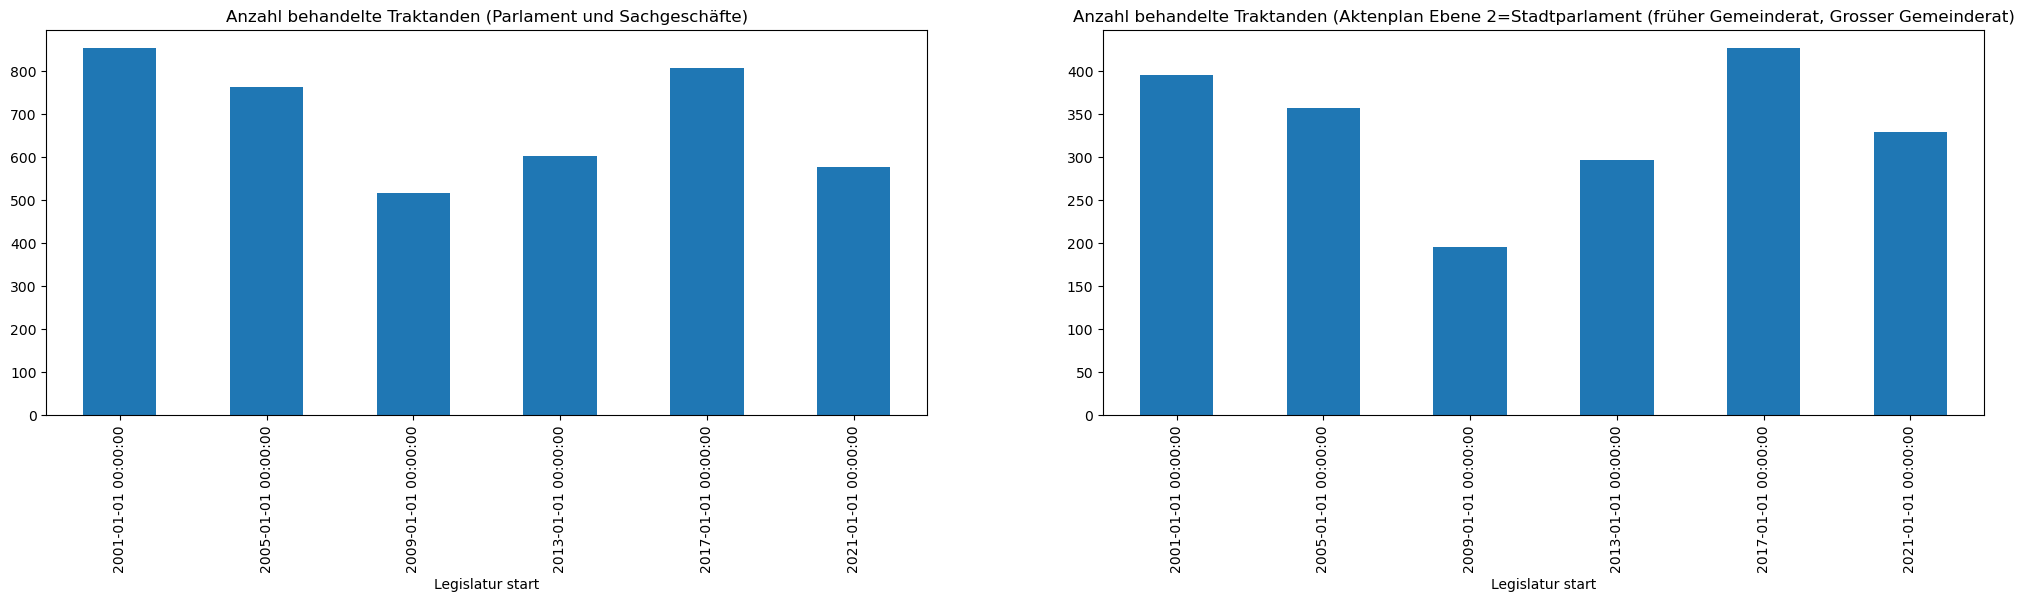

In [29]:
fig,axs = plt.subplots(1,2,figsize=(25,5))
df['Legislatur start'].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Anzahl behandelte Traktanden (Parlament und Sachgeschäfte)')
df_Parlament_gem_AP['Legislatur start'].value_counts().sort_index().plot.bar(ax=axs[1])

axs[1].set_title(f'Anzahl behandelte Traktanden (Aktenplan Ebene 2={Stadtparlament_txt}')

In [30]:
df_behandelt.shape,df_Parlament_gem_AP.shape

NameError: name 'df_behandelt' is not defined

In [31]:
df_Parlament_gem_AP = df_Parlament_gem_AP.set_index('Traktandum_GUID')#Geschaeft_GUID not unique

df_Parlament_gem_AP.head(2)

,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Legislatur start,Legislatur end
Traktandum_GUID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2d76d27f9b4e4ed087d04ea83c1e60b5,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2017-01-01,2020-12-31
e5bab329501544f9b51d800330171ad0,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,2017-01-01,2020-12-31


In [32]:
dfp = df_Parlament_gem_AP
urls = dfp['Download Traktandumsdokumente'].dropna().map(lambda x: Path(x))
urls.shape,urls.nunique() #URLs sind mehrfach gelistet!!!

((1998,), 1195)

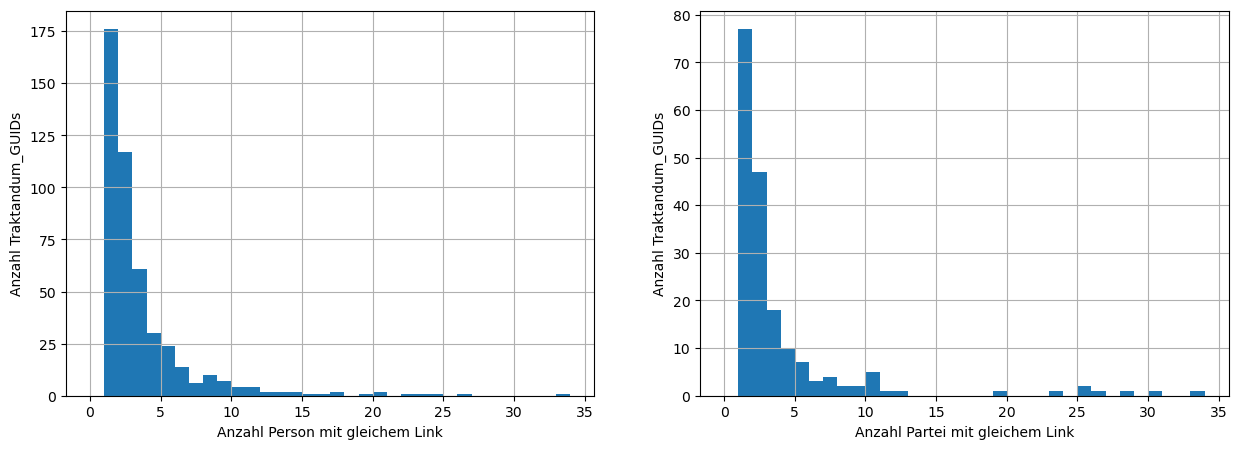

In [33]:
def spaltenhäufigkeitshistogramm(df,spalte,index='Traktandum_GUID'):
    df = df.reset_index().set_index(index)
    df[spalte].value_counts().hist(bins=np.arange(0,35))
    plt.xlabel(f'Anzahl {spalte} mit gleichem Link')
    plt.ylabel('Anzahl Traktandum_GUIDs')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
spaltenhäufigkeitshistogramm(df_Parlament_gem_AP,'Person')
plt.subplot(1,2,2)
spaltenhäufigkeitshistogramm(df_Parlament_gem_AP,'Partei')

In [34]:
dfp[dfp['Sitzungs_ID']==dfp['Sitzungs_ID'].value_counts().idxmax()].Traktandentitel.tolist()

['Einfache Anfrage Doris Königer und Alexandra Akeret: «Areal Stadtsäge – Projekt mit Vorbildcharakter»; Beantwortung',
 'Einfache Anfrage Stefan Grob: «Umweltfreundliches Streumittel für die Stadt St.Gallen?»; Beantwortung',
 'Interpellation SVP-Fraktion: "Massnahmen nach Steuerfussreduktion"; schriftlich',
 'Interpellation Oskar Seger: «Digitalisierungskonzept Stadtpolizei St.Gallen – Weniger Papierarbeit für mehr Sicherheit»; schriftlich',
 'Einfache Anfrage Manuela Ronzani: «Finanziert die Stadt Männerdiskriminierung mit?»; Beantwortung',
 'Interpellation René Neuweiler: "Parkplatzstrategie in der Innenstadt für Menschen mit einer Gehbehinderung"; schriftlich',
 'Interpellation Doris Königer und Lisa Etter Steinlin: "Breitfeld nicht nur ein Ort des Rückzugs"; schriftlich',
 'Einfache Anfrage Jenny Heeb (SP), Andrea Scheck (JUSO), Alexandra Akeret (SP): "Der Frauen*streik kommt – ist die Stadt St.Gallen bereit?"; Beantwortung',
 '«Baukultur: Innovation ohne Reue»; Postulatsbericht',

In [35]:
dfp[['Sitzungsdatum','Download_Protokoll','Geschaeft_GUID']]

,Sitzungsdatum,Download_Protokoll,Geschaeft_GUID
Traktandum_GUID,,,
2d76d27f9b4e4ed087d04ea83c1e60b5,2020-09-22,https://ftp-sg.oca.ch/stadtparlament/308062c45...,54eb7ecf39f644f48e4f60153cc6b5d8
e5bab329501544f9b51d800330171ad0,2020-09-22,https://ftp-sg.oca.ch/stadtparlament/308062c45...,a484d773ee614a42b279a494f7acf8d3
92d6c27378234db28fa9b377d7f41345,2020-09-22,https://ftp-sg.oca.ch/stadtparlament/308062c45...,bd0fd41e0ebd454b9c11be26337c9066
ccfe58f73a684fa4ab2adccb48ae11bf,2020-10-27,https://ftp-sg.oca.ch/stadtparlament/15124570b...,4e8802fdd0044c43bf8563627c6fbbf8
01689b6c84cd4a23ad4940eb7a5bbe92,2020-11-24,https://ftp-sg.oca.ch/stadtparlament/5f79375bd...,bf69b61af6c949a990091dbab73907be
...,...,...,...
f3206ae9e0694b8ca21dd07c97f28718,2016-08-23,https://ftp-sg.oca.ch/stadtparlament/3a12665f6...,5c090b8ecf934dfb9add1ffa543a5dcd
cf3fda7737724f1fbdf7ec6abd3d4dfb,2016-08-23,https://ftp-sg.oca.ch/stadtparlament/3a12665f6...,4c0c01b9c41d4149bc21fc8c7de0ff0d
ca821b9bdac74965814a7a3d246511b8,2016-08-23,https://ftp-sg.oca.ch/stadtparlament/3a12665f6...,8c86c32c500c40ec87a79ae1e01edf49


In [36]:
urls

Traktandum_GUID
2d76d27f9b4e4ed087d04ea83c1e60b5    https:/ftp-sg.oca.ch/stadtparlament/54eb7ecf39...
e5bab329501544f9b51d800330171ad0    https:/ftp-sg.oca.ch/stadtparlament/a484d773ee...
92d6c27378234db28fa9b377d7f41345    https:/ftp-sg.oca.ch/stadtparlament/bd0fd41e0e...
ccfe58f73a684fa4ab2adccb48ae11bf    https:/ftp-sg.oca.ch/stadtparlament/4e8802fdd0...
01689b6c84cd4a23ad4940eb7a5bbe92    https:/ftp-sg.oca.ch/stadtparlament/bf69b61af6...
                                                          ...                        
f3206ae9e0694b8ca21dd07c97f28718    https:/ftp-sg.oca.ch/stadtparlament/5c090b8ecf...
cf3fda7737724f1fbdf7ec6abd3d4dfb    https:/ftp-sg.oca.ch/stadtparlament/4c0c01b9c4...
ca821b9bdac74965814a7a3d246511b8    https:/ftp-sg.oca.ch/stadtparlament/8c86c32c50...
581b5c2675ca4b4f860e1906dbb757d0    https:/ftp-sg.oca.ch/stadtparlament/2e29175ad2...
1c49c3cd6ae94eadb24ded23bed2a17e    https:/ftp-sg.oca.ch/stadtparlament/7f67a1f35f...
Name: Download Traktandumsdokumente, L

In [37]:
uni = urls.map(lambda p:p.name).map(lambda s: Path(s).with_suffix('')).unique()
filelist_ser = pd.Series(uni,index=uni.astype('str')).map(lambda G_GUID: list((Text_Pfad/G_GUID).glob('*.txt')) if not pd.isnull(G_GUID) else '')

In [38]:
filelist_ser

54eb7ecf39f644f48e4f60153cc6b5d8    [/home/toedtli/opendatasg/verarbeitung/Text/54...
a484d773ee614a42b279a494f7acf8d3    [/home/toedtli/opendatasg/verarbeitung/Text/a4...
bd0fd41e0ebd454b9c11be26337c9066    [/home/toedtli/opendatasg/verarbeitung/Text/bd...
4e8802fdd0044c43bf8563627c6fbbf8    [/home/toedtli/opendatasg/verarbeitung/Text/4e...
bf69b61af6c949a990091dbab73907be    [/home/toedtli/opendatasg/verarbeitung/Text/bf...
                                                          ...                        
dbf8a4f6a5d5416f85a1cf291364ef95    [/home/toedtli/opendatasg/verarbeitung/Text/db...
a14d97ca752d443dbb09675a37e289de    [/home/toedtli/opendatasg/verarbeitung/Text/a1...
5c090b8ecf934dfb9add1ffa543a5dcd    [/home/toedtli/opendatasg/verarbeitung/Text/5c...
4c0c01b9c41d4149bc21fc8c7de0ff0d    [/home/toedtli/opendatasg/verarbeitung/Text/4c...
8c86c32c500c40ec87a79ae1e01edf49    [/home/toedtli/opendatasg/verarbeitung/Text/8c...
Length: 1195, dtype: object

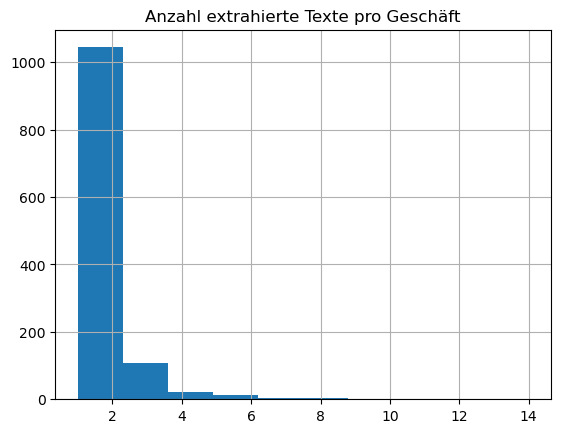

In [39]:
filelist_ser.map(len).hist()
plt.title('Anzahl extrahierte Texte pro Geschäft');

530323

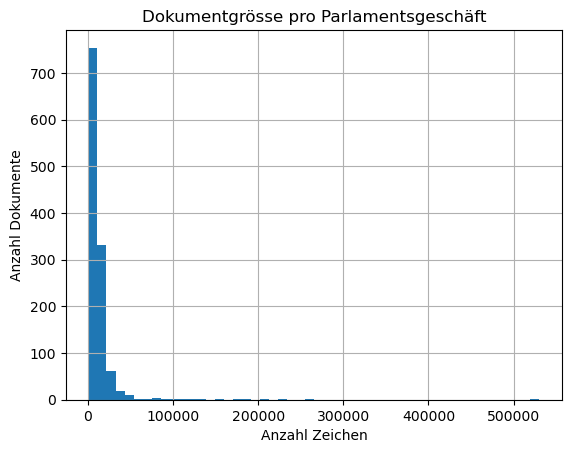

In [40]:
import codecs
def read_and_concat(filelist):
    text = ''
    for file in filelist:
        try:
            with codecs.open(file,'r',encoding='utf-8') as fh:
                lines = fh.readlines()
            text += ''.join(lines)
        except FileNotFoundError as err:
            print(file)
            continue
    return text
single_text_per_G_GUID = filelist_ser.map(read_and_concat)
single_text_per_G_GUID.name = 'Volltext'
single_text_per_G_GUID.map(len).hist(bins=50);plt.xlabel('Anzahl Zeichen');plt.ylabel('Anzahl Dokumente');plt.title('Dokumentgrösse pro Parlamentsgeschäft')
single_text_per_G_GUID.map(len).max()

In [41]:
#single_text_per_G_GUID = single_text_per_G_GUID[single_text_per_G_GUID.map(len)>0] Damit gingen Dokumente verloren!
single_text_per_G_GUID

54eb7ecf39f644f48e4f60153cc6b5d8    AK/st_ga lien Stadtparlament Rathaus 9001 St.G...
a484d773ee614a42b279a494f7acf8d3    Parlamentarischer Vorstoss e_u cit itiv(7 Moti...
bd0fd41e0ebd454b9c11be26337c9066    Ä rAtigallen Stadt St.Gallen Stadtparlament oe...
4e8802fdd0044c43bf8563627c6fbbf8    iffst.gallen Stadt St.Gallen Stadtparlament Pa...
bf69b61af6c949a990091dbab73907be    Vorlage Stadtparlament Datum 17. September 202...
                                                          ...                        
dbf8a4f6a5d5416f85a1cf291364ef95     Stadt St.Gallen Stadtrat Vorlage Stadtparlame...
a14d97ca752d443dbb09675a37e289de    office@martin-wuermli.ch bru_tho@bluewin.ch St...
5c090b8ecf934dfb9add1ffa543a5dcd    Susanne Schmid- Keller - Wenigerstrasse 18b - ...
4c0c01b9c41d4149bc21fc8c7de0ff0d    Stadt St.Gallen Stadtrat Vorlage Stadtparlamen...
8c86c32c500c40ec87a79ae1e01edf49    Stadt St.Gallen Stadtparlament Rathaus 9001 St...
Name: Volltext, Length: 1195, dtype: object

In [42]:
dfjoined = dfp.reset_index().join(single_text_per_G_GUID,on='Geschaeft_GUID',how='left',lsuffix='dfp',rsuffix='txt')

In [43]:
dfjoined.Volltext.map(len).median(),dfjoined.Volltext.map(len).quantile(0.1),dfjoined.Volltext.map(len).quantile(0.9)

(9487.0, 4186.1, 22185.6)

In [44]:
#dfjoined.Volltext.map(len).hist(bins=50);

In [45]:
dfjoined.Volltext.isnull().sum()

0

In [46]:
dfjoined.index.isnull().sum()

0

In [47]:
print(dfjoined.shape)
dfjoined.head(5)

(1998, 39)


,Traktandum_GUID,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Legislatur start,Legislatur end,Volltext
0,2d76d27f9b4e4ed087d04ea83c1e60b5,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2017-01-01,2020-12-31,AK/st_ga lien Stadtparlament Rathaus 9001 St.G...
1,e5bab329501544f9b51d800330171ad0,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,2017-01-01,2020-12-31,Parlamentarischer Vorstoss e_u cit itiv(7 Moti...
2,92d6c27378234db28fa9b377d7f41345,2020-09-22T00:00:00.000-19,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/bd0fd41e0...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP/JUSO/PFG-Fraktion: Reglement...,NaN,behandelt,19.0,bd0fd41e0ebd454b9c11be26337c9066,2017-01-01,2020-12-31,Ä rAtigallen Stadt St.Gallen Stadtparlament oe...
3,ccfe58f73a684fa4ab2adccb48ae11bf,2020-10-27T00:00:00.000-10,f204718502654abf8818edc73721d4c0,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,50. Sitzung Stadtparlament,2020-10-27,Öffentlich,Olma Messen; Halle 2.1,16:00

In [48]:
dfp.Traktandentitel

Traktandum_GUID
2d76d27f9b4e4ed087d04ea83c1e60b5    Neuordnung der Partizipation von Bevölkerungsg...
e5bab329501544f9b51d800330171ad0    Interpellation SP-JUSO-PFG Fraktion: «Unterstü...
92d6c27378234db28fa9b377d7f41345    Interpellation SP/JUSO/PFG-Fraktion: Reglement...
ccfe58f73a684fa4ab2adccb48ae11bf                      VBSG-Linie 11; Postulatsbericht
01689b6c84cd4a23ad4940eb7a5bbe92    Bericht über Zu- und Wegzüge in und aus der St...
                                                          ...                        
f3206ae9e0694b8ca21dd07c97f28718    Einfache Anfrage Susanne Schmid: Wird der Park...
cf3fda7737724f1fbdf7ec6abd3d4dfb    Interpellation FDP-Fraktion: Kreisel - Mehr Kr...
ca821b9bdac74965814a7a3d246511b8    Interpellation FDP-Fraktion: St.Gallen als Pio...
581b5c2675ca4b4f860e1906dbb757d0    Interpellation Beatrice Truniger: Mutterschaft...
1c49c3cd6ae94eadb24ded23bed2a17e    Postulat Jürg Brunner: Erlass einer Tempo 30-Z...
Name: Traktandentitel, Length: 1998, d

In [49]:
dfjoined.columns

Index(['Traktandum_GUID', 'nr', 'Sitzungs_ID', 'Link zur Sitzung',
       'Legislatur', 'Jahr', 'Bezeichnung', 'Sitzungsdatum', 'Freigabe', 'Ort',
       'Zeit', 'Bemerkungen', 'Download_Sitzung', 'Download_Protokoll',
       'Aktenplan', 'Geschaeftstyp', 'Person', 'Partei',
       'Download Traktandumsdokumente', 'Link zum Traktandum',
       'Aktenplannummer', 'Gliederung', 'Gliederungsnummer',
       'Aktenplan Ebene1', 'Aktenplan Ebene2', 'Aktenplan Ebene3',
       'Aktenplan Ebene4', 'Aktenplan Ebene5', 'Aktenplan Ebene6',
       'Dokumentendatum', 'Dokumententitel', 'Traktandentitel',
       'Vorberatende Kommission', 'Traktandenstatus', 'Traktandennummer',
       'Geschaeft_GUID', 'Legislatur start', 'Legislatur end', 'Volltext'],
      dtype='object')

In [50]:
dfjoined[['Sitzungsdatum','Volltext']]

,Sitzungsdatum,Volltext
0,2020-09-22,AK/st_ga lien Stadtparlament Rathaus 9001 St.G...
1,2020-09-22,Parlamentarischer Vorstoss e_u cit itiv(7 Moti...
2,2020-09-22,Ä rAtigallen Stadt St.Gallen Stadtparlament oe...
3,2020-10-27,iffst.gallen Stadt St.Gallen Stadtparlament Pa...
4,2020-11-24,Vorlage Stadtparlament Datum 17. September 202...
...,...,...
1993,2016-08-23,Susanne Schmid- Keller - Wenigerstrasse 18b - ...
1994,2016-08-23,Stadt St.Gallen Stadtrat Vorlage Stadtparlamen...
1995,2016-08-23,Stadt St.Gallen Stadtparlament Rathaus 9001 St...
1996,2016-09-20,Stadt St.Gallen Stadtparlament Rathaus 9001 St...


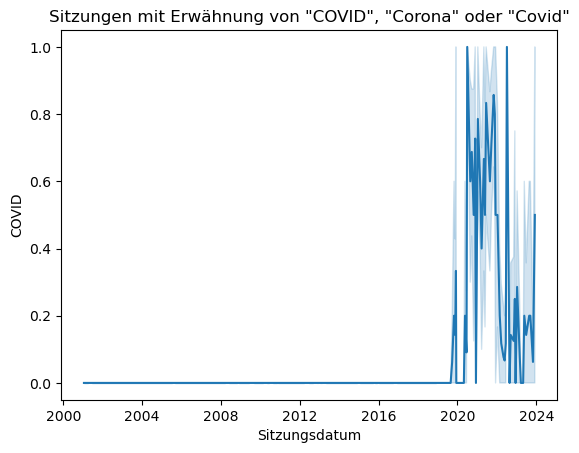

In [61]:
xy = dfjoined[['Sitzungsdatum','Volltext']].copy()
xy['COVID'] = xy['Volltext'].str.contains('COVID|Corona|Covid')
xy = xy[~xy.Sitzungsdatum.isnull()]
xy['eins']=1
sns.lineplot(x='Sitzungsdatum',y='COVID',  data=xy)
plt.title('Sitzungen mit Erwähnung von "COVID", "Corona" oder "Covid"')
plt.savefig('COVID.svg',transparent=True)

In [52]:
#xz.groupby(xz.index)["COVID"].mean().plot()

In [53]:
import matplotlib.dates as mdates
xz = xy.set_index('Sitzungsdatum')
xz.COVID.map({False:0,True:1}).value_counts()

COVID
0    1849
1     149
Name: count, dtype: int64

<Axes: xlabel='Sitzungsdatum', ylabel='COVID'>

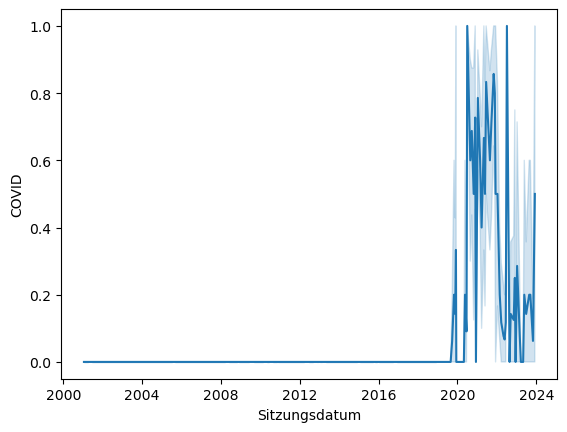

In [54]:
xy = dfjoined[['Sitzungsdatum','Volltext']].copy()
xy['COVID'] = xy['Volltext'].str.contains('COVID|Corona|Virus|Covid')
xy = xy[~xy.Sitzungsdatum.isnull()]
xy['eins']=1
sns.lineplot(x='Sitzungsdatum',y='COVID',  data=xy)

In [55]:
xy.Sitzungsdatum.max()

Timestamp('2023-12-05 00:00:00')

<Axes: >

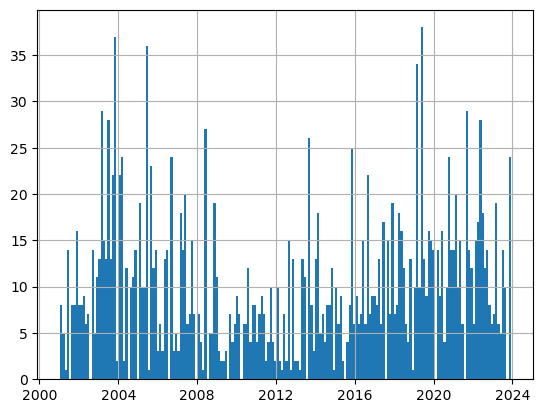

In [56]:
xy.Sitzungsdatum.hist(bins=200)

In [57]:
dfjoined.to_excel('Daten_Parlament_v2.xlsx')

In [58]:
dfjoined.head(5)

,Traktandum_GUID,nr,Sitzungs_ID,Link zur Sitzung,Legislatur,Jahr,Bezeichnung,Sitzungsdatum,Freigabe,Ort,Zeit,Bemerkungen,Download_Sitzung,Download_Protokoll,Aktenplan,Geschaeftstyp,Person,Partei,Download Traktandumsdokumente,Link zum Traktandum,Aktenplannummer,Gliederung,Gliederungsnummer,Aktenplan Ebene1,Aktenplan Ebene2,Aktenplan Ebene3,Aktenplan Ebene4,Aktenplan Ebene5,Aktenplan Ebene6,Dokumentendatum,Dokumententitel,Traktandentitel,Vorberatende Kommission,Traktandenstatus,Traktandennummer,Geschaeft_GUID,Legislatur start,Legislatur end,Volltext
0,2d76d27f9b4e4ed087d04ea83c1e60b5,2020-09-22T00:00:00.000-5,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.10 Stadtparlament: Motionen,Parlamentarische Vorstösse/Motion,Hasler Etrit;Grob Stefan;Niederhauser Nadine;T...,SP;Die Mitte;glp;Grüne,https://ftp-sg.oca.ch/stadtparlament/54eb7ecf3...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.10,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.10,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Motionen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Neuordnung der Partizipation von Bevölkerungsg...,NaN,behandelt,5.0,54eb7ecf39f644f48e4f60153cc6b5d8,2017-01-01,2020-12-31,AK/st_ga lien Stadtparlament Rathaus 9001 St.G...
1,e5bab329501544f9b51d800330171ad0,2020-09-22T00:00:00.000-18,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/a484d773e...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP-JUSO-PFG Fraktion: «Unterstü...,NaN,behandelt,18.0,a484d773ee614a42b279a494f7acf8d3,2017-01-01,2020-12-31,Parlamentarischer Vorstoss e_u cit itiv(7 Moti...
2,92d6c27378234db28fa9b377d7f41345,2020-09-22T00:00:00.000-19,2ca35017a57c417b97a5697f8efa691b,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,49. Sitzung Stadtparlament,2020-09-22,Öffentlich,Olma Messen; Halle 2.1,16:00,open end,https://ftp-sg.oca.ch/stadtparlament/2ca35017a...,https://ftp-sg.oca.ch/stadtparlament/308062c45...,152.15.12 Stadtparlament: Interpellationen,Parlamentarische Vorstösse/Interpellation,NaN,NaN,https://ftp-sg.oca.ch/stadtparlament/bd0fd41e0...,https://www.stadt.sg.ch/home/verwaltung-politi...,152.15.12,1 Grundlagen / 15 Stadtparlament (früher Gemei...,1 / 15 / 152 / 152.15 / 152.15.12,Grundlagen,"Stadtparlament (früher Gemeinderat, Grosser Ge...",Stadtparlament: Sitzungen,Stadtparlament: Parlamentarische Vorstösse,Stadtparlament: Interpellationen,NaN,2020-09-04,Beschlussprotokoll Stadtparlament mit Abstimmu...,Interpellation SP/JUSO/PFG-Fraktion: Reglement...,NaN,behandelt,19.0,bd0fd41e0ebd454b9c11be26337c9066,2017-01-01,2020-12-31,Ä rAtigallen Stadt St.Gallen Stadtparlament oe...
3,ccfe58f73a684fa4ab2adccb48ae11bf,2020-10-27T00:00:00.000-10,f204718502654abf8818edc73721d4c0,https://www.stadt.sg.ch/home/verwaltung-politi...,01.01.2017 - 31.12.2020,2020,50. Sitzung Stadtparlament,2020-10-27,Öffentlich,Olma Messen; Halle 2.1,16:00

In [59]:
with open('Text_all.txt','w') as fh:
    fh.write('\n'.join(dfjoined.Volltext.map(lambda x: x+'\n').tolist()))

In [60]:
dfjoined.columns

Index(['Traktandum_GUID', 'nr', 'Sitzungs_ID', 'Link zur Sitzung',
       'Legislatur', 'Jahr', 'Bezeichnung', 'Sitzungsdatum', 'Freigabe', 'Ort',
       'Zeit', 'Bemerkungen', 'Download_Sitzung', 'Download_Protokoll',
       'Aktenplan', 'Geschaeftstyp', 'Person', 'Partei',
       'Download Traktandumsdokumente', 'Link zum Traktandum',
       'Aktenplannummer', 'Gliederung', 'Gliederungsnummer',
       'Aktenplan Ebene1', 'Aktenplan Ebene2', 'Aktenplan Ebene3',
       'Aktenplan Ebene4', 'Aktenplan Ebene5', 'Aktenplan Ebene6',
       'Dokumentendatum', 'Dokumententitel', 'Traktandentitel',
       'Vorberatende Kommission', 'Traktandenstatus', 'Traktandennummer',
       'Geschaeft_GUID', 'Legislatur start', 'Legislatur end', 'Volltext'],
      dtype='object')